In [2]:
import pandas as pd
import numpy as np

train_data=pd.read_csv("./train.csv")
test_data=pd.read_csv("./test.csv")
# print(test_data.head())

# Splitting the train data to check underfitting/overfitting etc.
train=train_data.sample(frac=0.8)
test=train_data.drop(train.index)

In [3]:
Y=np.array(train)[:,2]
X=np.array(train)[:,1].reshape(-1,1)
Y_test=np.array(test)[:,2]
X_test=np.array(test)[:,1]

def trainModel(m, X, Y):
    ### Degree of polynomial m
    indices=np.arange(0, m+1).reshape(1,-1)
    X=X**indices 
    # X is now nx(m+1) matrix, n=320

    ### B=(X'X)^-1.(X'Y)
    XtX=np.matmul(X.transpose(),X)
    XtY=np.matmul(X.transpose(),Y)
    B=np.matmul(np.linalg.inv(np.float64(XtX)),XtY)
    return B

def resultingPolynomial(B, X):
    m=B.size-1
    indices=np.arange(0, m+1).reshape(1,-1)
    X=X**indices 

    Y_estimated=np.matmul(X, B)
    return Y_estimated

def sumSquareResiduals(B, X, Y):
    Y_est=resultingPolynomial(B,X)
    return np.sum((Y-Y_est)**2)

def findBestFit(X, Y):
    minM=0
    minSSR=np.infty
    # minB=np.zeros(10) # init 
    arrayB=[]
    for i in range(1, 51): # m from 1 to 50
        B=trainModel(i, X, Y)
        SSR=sumSquareResiduals(B, X_test.reshape(-1,1), Y_test)
        arrayB.append(B)
        if SSR<minSSR:
            minSSR=SSR
            minM=i
            # minB=B
    return minM, arrayB[minM-1], arrayB[minM-2], arrayB[minM]
    # best m, bestfit B, underfit B, overfit B

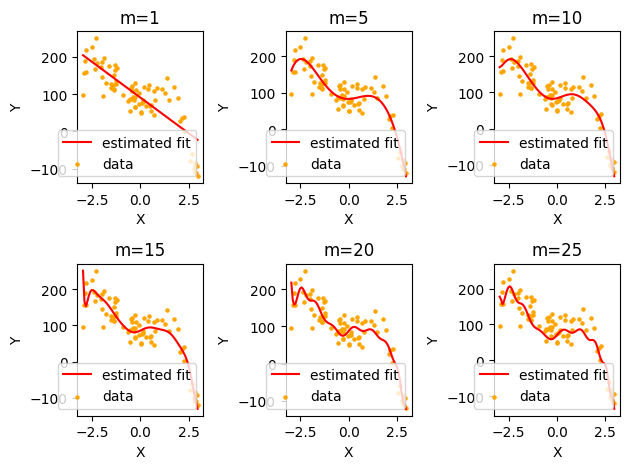

In [4]:
import matplotlib.pyplot as plt

def trainAndVisualizePerformance(i):
    # for m=2, 5, 10 , 15, 20, 25
    m=1 if i==0 else i*5
    # m=i+1
    B=trainModel(m, X, Y)
    X_range=np.linspace(X_test.min(), X_test.max(), X_test.shape[0])
    Y_est=resultingPolynomial(B, X_range.reshape(-1,1))
    SSR=np.sum((Y_test-Y_est)**2)

    plt.subplot(2,3,i+1)
    plt.plot(X_range, Y_est, 'r-', label="estimated fit")
    plt.scatter(X_test, Y_test, c='orange', s=5, label="data")
    plt.title(f"m={m}")
    # plt.xlabel(f"SSR={SSR:.2E}")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()

for i in range(0, 6) : trainAndVisualizePerformance(i)
plt.tight_layout()
plt.show()

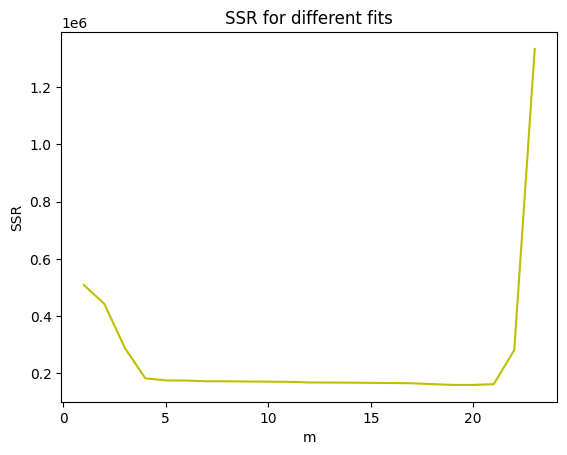

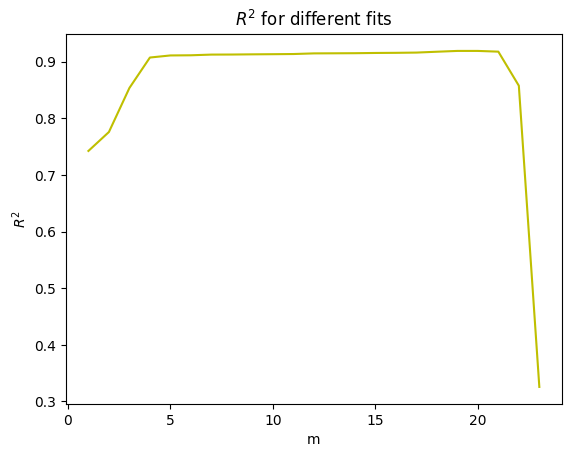

In [5]:
# plot ssr
def visualizeSSR():
    SSR_range=[]
    for i in range(1, 24): # m from 1 to 50
        B=trainModel(i, X, Y)
        SSR_range.append(sumSquareResiduals(B, X, Y))
    X_range=np.arange(1,24)
    plt.plot(X_range, SSR_range, 'y-')
    plt.title("SSR for different fits")
    plt.xlabel("m")
    plt.ylabel("SSR")
    plt.show()
    return SSR_range

def visualizeRsquare(SSR):
    SYY=np.sum((Y-Y.mean())**2)
    R_square=1-SSR/SYY
    X_range=np.arange(1,24)
    plt.plot(X_range, R_square, 'y-')
    plt.title(r"$R^2$ for different fits")
    plt.xlabel("m")
    plt.ylabel(r"$R^2$")
    plt.show()

SSR=visualizeSSR()
visualizeRsquare(np.array(SSR))

m=5


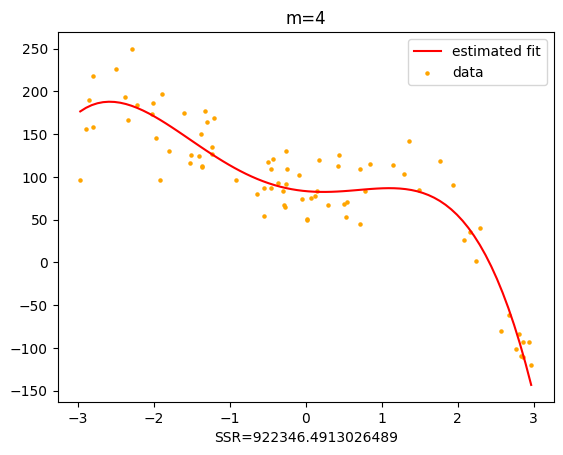

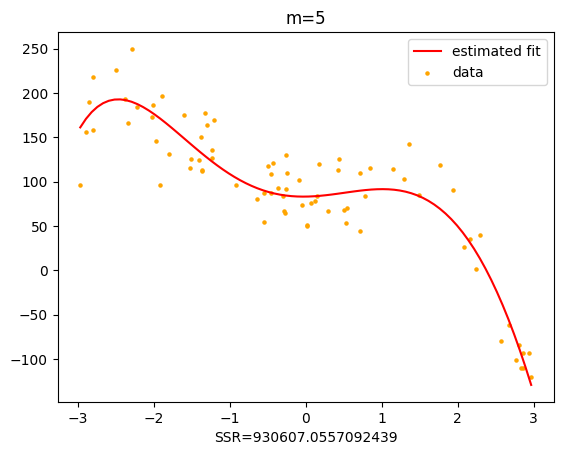

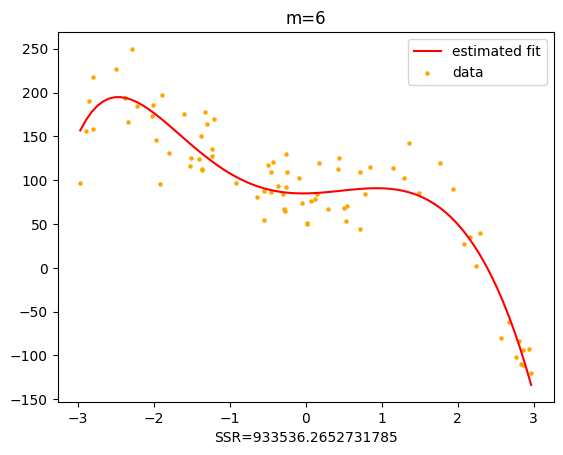

In [6]:
m_best, B_best, B_under, B_over=findBestFit(X,Y)
print(f"m={m_best}")

def generateDifferentFits(m, B, name):
    # B=trainModel(m, X, Y)
    X_range=np.linspace(X_test.min(), X_test.max(), X_test.shape[0])
    Y_est=resultingPolynomial(B, X_range.reshape(-1,1))
    SSR=np.sum((Y_test-Y_est)**2)

    plt.plot(X_range, Y_est, 'r-', label="estimated fit")
    plt.scatter(X_test, Y_test, c='orange', s=5, label="data")
    plt.title(f"m={m}")
    plt.xlabel(f"SSR={SSR}")
    # plt.ylabel("Y")
    plt.legend()
    plt.savefig(name)
    plt.show()

generateDifferentFits(m_best-1, B_under, "3_underfit.png")
generateDifferentFits(m_best, B_best, "3_correctfit.png")
generateDifferentFits(m_best+1, B_over, "3_overfit.png")

In [7]:
import pickle

def finalModel(m):
    # train on the whole data
    Ynew=np.array(train_data)[:,2]
    Xnew=np.array(train_data)[:,1].reshape(-1,1)

    indices=np.arange(0, m+1).reshape(1,-1)
    Xnew=Xnew**indices 
    # X is now 400x(m+1) matrix

    ### B=(X'X)^-1.(X'Y)
    XtX=np.matmul(Xnew.transpose(),Xnew)
    XtY=np.matmul(Xnew.transpose(),Ynew)
    B=np.matmul(np.linalg.inv(np.float64(XtX)),XtY)

    # Save beta
    # np.save('weights.npy', B)
    with open('3_weights.pkl', 'wb') as f:
        pickle.dump(np.array(B), f)
    return B

final_B=finalModel(m_best)
final_X_test=np.array(test_data)[:,1].reshape(-1,1)
y_predict=resultingPolynomial(final_B, final_X_test)
predictions=test_data.assign(y=y_predict)
predictions.to_csv("3_predictions.csv")